__Your name here__
<br>
Date: Feb. 14, 2022
<br>
PHYS 2030 W22

# <center><font color=#46769B>Exercise 15: MCMCs for rotation curve data</font></center>

## <font color=#46769B>Introduction</font>

In Exercise 11 and 12, we showed that importance sampling can be used to determine the preferred parameters of a model to fit the data. Here we consider how this works using the Metropolis MCMC algorithm.

Our previous MCMC simulations considered only a single discrete or continuous variable. Here we will generalize to the case of multivariate PDFs with more than one continuous variable.

Our goals for this notebook are:
- Generalize our MCMC algorithm to sampling from more than one variable
- Gain experience using MCMC algorithms to fit theoretical models to data

Required reading:
- *Lesson 7: MCMCs for continuous variables*


## <font color=#46769B>Metropolis algorithm for multivariate distributions</font>

Suppose we have a target PDF $P(x,y)$, where $x,y$ is two continuous variables that we want to sample. It is helpful to consider our variables as a vector $\vec{r} = (x,y)$. We will also write our PDF as $P(\vec r)$.

Let's go through the general procedure for performing an MCMC simulation, highlighting the differences with the univariate case.

### <font color=#46769B>Proposal distribution</font>

The first step is to choose the proposal (transition) PDF. We write this as $Q(x,y|x^\prime,y^\prime)$ or $Q(\vec r|\vec r^\prime)$, where $\vec{r} = (x,y)$ is the new sample and $\vec{r}^\prime = (x^\prime,y^\prime)$ is the old sample. 
We could have a *factorizable* proposal PDF
$$ Q(\vec r|\vec r^\prime) = Q_x(x|x^\prime) \, Q_y(y|y^\prime) \, ,$$
which means that $x$ only depends on $x^\prime$ and $y$ only depends on $y^\prime$.
But in general, $x$ can depend on both $x^\prime,y^\prime$ (and similarly for $y$) if $Q$ is not factorizable.

In the Metropolis algorithm, the proposal distribution is assumed to be symmetric, i.e.,
$$Q(\vec{r}|\vec r^\prime) = Q(\vec r^\prime|\vec r) \, .$$
There are two common choices commonly adopted for $Q$. 
1. Assume $Q$ is factorizable and take (univariate) normal distributions for $Q_x$ and $Q_y$, each centered at the previous point $x^\prime$ or $y^\prime$, respectively:
$$Q(x|x^\prime) = \frac{1}{\sqrt{2\pi \sigma_{x}^2}} \, e^{-\frac{(x-x^\prime)^2}{2 \sigma_{x}^2}} \, , \qquad
Q(y|y^\prime) = \frac{1}{\sqrt{2\pi \sigma_{y}^2}} \, e^{-\frac{(y-y^\prime)^2}{2 \sigma_{y}^2}} \, .$$
Here we are free to tune the widths of both distributions, $\sigma_x$ and $\sigma_y$, independently. For example, if we want a large step-size in $x$ and a small step-size in $y$, we can take a large value of $\sigma_x$ and a small value of $\sigma_y$, as needed. 
2. Take a multivariate normal distribution for $Q$, centered at the previous point $\vec{r}^\prime$:
$$ Q(x,y) = 
\frac{1}{2\pi \sqrt{\det(C)}} \, \exp\left(-\frac{1}{2} (\vec{r} - \vec{r}^\prime)^T C^{-1} (\vec{r} - \vec{r}^\prime)\right) \, . $$
Here we are free to tune the covariance matrix $C$. If you choose $C = {\rm diag}(\sigma_x^2, \sigma_y^2)$, this reduces to the factorizable case above.
However, in situations were $x$ and $y$ are correlated, it can dramatically improve the performance of your MCMC simulations to include a nondiagonal covariance matrix when sampling.

No matter which choice you adopt, generally you will not know from the outset the best values of $\sigma_{x,y}$ or $C$. There will be an initial process where you __tune__ these parameters.

### <font color=#46769B>Choosing your initial point</font>

In the multivariate case, we choose by hand starting points for all variables, i.e., $\vec{r}_0 = (x_0,y_0)$.  The rule of thumb is: *Choose values of $x_0,y_0$ that you wouldn't mind sampling later on in your chain*. As you tune your MCMC simulations, you can refine your initial values for subsequent simulations.

### <font color=#46769B>Acceptance/rejection</font>

The process for accepting or rejecting a new sample is the same as we discussed for univariate distributions. Here we recap the steps:
- Given a previous sample $\vec{r}^\prime = \vec{r}_{i-1} = (x_{i-1},y_{i-1})$, generate a new sample $\vec{r} = (x,y)$ by sampling from $Q(\vec{r}|\vec{r}^\prime)$.
- Calculate the acceptance ratio $\mathcal{A} = P(\vec{r})/P(\vec{r}_{i-1})$.
    - If $\mathcal{A} > 1$, we *always* accept the new point.
    - If $\mathcal{A} < 1$, we *either* accept or reject the new point. We decide to accept or reject randomly: we accept with probability $\mathcal{A}$ (and therefore we reject with probability $1-\mathcal{A}$).
- The next values in the chain, $x_i$ and $y_i$, depend on whether we accept or reject:
    - If we accept $\vec{r}$, we set both $x_i = x$ and $y_i = y$, i.e., saving our new samples to the chain.
    - If we reject $\vec{r}$, we set both $x_i = x_{i-1}$ and $y_i = y_{i-1}$, i.e., *repeating our previous values in the chain*. 

Note that all the variables $\vec{r} = (x,y)$ are accepted or rejected together. You never, say, accept $x$ but reject $y$.

## <font color=#46769B>Exercise</font>

Let's consider the rotation curve data for galaxy DDO154 provided in Exercise 11. Using the Metropolis MCMC algorithm, the goal is to determine the total mass $M_{\rm tot}$ of DDO 154. 

Here is the data:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data

# radius (kpc) 
radius = np.array([0.14, 0.29, 0.43, 0.57, 0.72, 0.86, 1.  , 1.15, 1.29, 1.44, 1.58,
                   1.72, 1.87, 2.01, 2.15, 2.3 , 2.44, 2.58, 2.73, 2.87, 3.01, 3.16,
                   3.3 , 3.44, 3.59, 3.73, 3.87, 4.02, 4.16, 4.31, 4.45, 4.59, 4.74,
                   4.88, 5.02, 5.17, 5.31, 5.45, 5.6 , 5.74, 5.88, 6.03, 6.17, 6.31,
                   6.46, 6.6 , 6.74, 6.89, 7.03, 7.18, 7.32, 7.46, 7.61, 7.75, 7.89])

# mean circular velocity v (km/s) 
mu = np.array([  5.77, 10.98, 14.65, 16.02, 19.01, 21.58, 24.06, 24.68, 26.55,
                29.44, 31.67, 33.67, 34.35, 35.06, 36.08, 36.16, 37.32, 38.39,
                39.8 , 40.48, 41.13, 42.01, 42.8 , 43.19, 43.91, 44.44, 45.02,
                45.79, 46.22, 46.81, 47.13, 46.73, 46.98, 46.54, 45.47, 47.11,
                46.96, 45.65, 44.21, 44.21, 44.63, 45.9 , 44.66, 44.7 , 45.64,
                44.01, 43.69, 45.49, 46.04, 44.67, 47.02, 50.15, 50.72, 48.32, 50.42])

# error for circular velocity v (km/s) 
sigma = np.array([2.59, 2.43, 2.15, 3.09, 2.62, 2.61, 2.34, 2.97, 5.39, 6.27, 6.34,
                  7.09, 7.31, 6.57, 6.35, 5.53, 5.24, 4.96, 4.85, 4.81, 4.33, 4.13,
                  3.78, 3.37, 3.41, 3.37, 3.43, 3.71, 3.65, 4.18, 4.72, 4.55, 4.53,
                  4.63, 4.68, 4.81, 4.71, 5.02, 5.16, 4.97, 5.49, 5.25, 4.78, 5.74,
                  5.77, 6.18, 5.95, 5.41, 5.58, 4.76, 5.66, 6.54, 5.12, 6.92, 5.61])
              
plt.errorbar(radius,mu,yerr=sigma,fmt='.',label='DDO154 data') 
plt.xlabel('Radius (kpc)')
plt.ylabel('Circular velocity (km/s)')
plt.title('Rotation curve')

plt.legend()
plt.show()


## <font color=#46769B>Part (a)</font>

The first step is to enter your code from Exercise 11 for calculating the $\chi^2(x,y)$ and probability $P(x,y)$, as a function of $x,y$. Just to recap the logic from Exercise 11:
- Write a function `chi_sq(x,y)` that will compute $\chi^2(x,y)$ for a given input values of $x,y$. The formula is
$$\chi^2(x,y) = \sum_{k=1}^n \frac{(f_k(x,y) - \mu_k)^2}{\sigma_k^2}$$
where the $\mu_k$ and $\sigma_k$ are the circular velocity means `mu` and uncertainties for the data `sigma` (given above).
The model prediction for the circular velocity is
$$f_k(x,y) = \sqrt{ \frac{G_N}{r_k} \frac{M_{\rm tot} r_k^3}{(r_k+a)^3}} = \sqrt{ \frac{G_N 10^y r_k^2}{(r_k+10^x)^3}} $$
where $r_k$ values are radius values in `radius` (given above). Also, Newton's constant in the appropriate units is $G_N = 4.302 \times 10^{-6} \; {\rm (km/s)^2} \,{\rm kpc}/M_{\odot}$.
- Write a function 
```py
def P(x,y):
    return np.exp(-0.5*chi_sq(x,y))
```
to compute the target distribution. (Note the overall normalizing constant is irrelevant for MCMC algorithms.)

[0.6, 0.6, 0.6, 0.6, 0.6, 0.5188473749902702, 0.5188473749902702, 0.5188473749902702, 0.5188473749902702, 0.5188473749902702, 0.45388869630629086, 0.45388869630629086, 0.45388869630629086, 0.46782313532694936, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.46159631567182713, 0.4972330400036609, 0.4972330400036609, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 0.5127236120007514, 

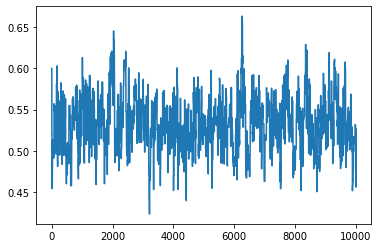

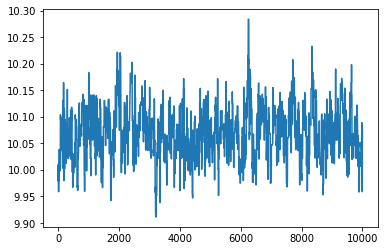

In [22]:
# Your code for chi_sq(x,y) and P(x,y) here (from Exercise 11)

import numpy as np
import matplotlib.pyplot as plt


# Data

# radius (kpc) 
radius = np.array([0.14, 0.29, 0.43, 0.57, 0.72, 0.86, 1.  , 1.15, 1.29, 1.44, 1.58,
                   1.72, 1.87, 2.01, 2.15, 2.3 , 2.44, 2.58, 2.73, 2.87, 3.01, 3.16,
                   3.3 , 3.44, 3.59, 3.73, 3.87, 4.02, 4.16, 4.31, 4.45, 4.59, 4.74,
                   4.88, 5.02, 5.17, 5.31, 5.45, 5.6 , 5.74, 5.88, 6.03, 6.17, 6.31,
                   6.46, 6.6 , 6.74, 6.89, 7.03, 7.18, 7.32, 7.46, 7.61, 7.75, 7.89])

# mean circular velocity v (km/s) 
mu = np.array([  5.77, 10.98, 14.65, 16.02, 19.01, 21.58, 24.06, 24.68, 26.55,
                29.44, 31.67, 33.67, 34.35, 35.06, 36.08, 36.16, 37.32, 38.39,
                39.8 , 40.48, 41.13, 42.01, 42.8 , 43.19, 43.91, 44.44, 45.02,
                45.79, 46.22, 46.81, 47.13, 46.73, 46.98, 46.54, 45.47, 47.11,
                46.96, 45.65, 44.21, 44.21, 44.63, 45.9 , 44.66, 44.7 , 45.64,
                44.01, 43.69, 45.49, 46.04, 44.67, 47.02, 50.15, 50.72, 48.32, 50.42])

# error for circular velocity v (km/s) 
sigma = np.array([2.59, 2.43, 2.15, 3.09, 2.62, 2.61, 2.34, 2.97, 5.39, 6.27, 6.34,
                  7.09, 7.31, 6.57, 6.35, 5.53, 5.24, 4.96, 4.85, 4.81, 4.33, 4.13,
                  3.78, 3.37, 3.41, 3.37, 3.43, 3.71, 3.65, 4.18, 4.72, 4.55, 4.53,
                  4.63, 4.68, 4.81, 4.71, 5.02, 5.16, 4.97, 5.49, 5.25, 4.78, 5.74,
                  5.77, 6.18, 5.95, 5.41, 5.58, 4.76, 5.66, 6.54, 5.12, 6.92, 5.61])
              

GN = 4.302e-6
N=10**4               ################## 10**5 samples overloads output, reduced to 10**4
y0=10
x0=0.6
sigma_x=0.05
sigma_y=0.05
def chi_sq(x,y):
    a = 10**x
    Mtot = 10**y
    M = Mtot*radius**3/(a+radius)**3
    f = np.sqrt(GN*M/radius)  
    return np.sum((f-mu)**2/sigma**2)

def P(x,y):
    return np.exp(-0.5*chi_sq(x,y))
x_samples=[x0]
y_samples=[y0]

for i in range(N-1):
  x_old=x_samples[i]
  y_old=y_samples[i]
  x_new=np.random.normal(x_old,sigma_x)
  y_new=np.random.normal(y_old,sigma_y)
  A=P(x_new,y_new)/P(x_old,y_old)
  if A>1:
    x_samples.append(x_new)
    y_samples.append(y_new)
  else:
    r=np.random.rand()
    if r< A:
      x_samples.append(x_new)
      y_samples.append(y_new)
    else:
      x_samples.append(x_old)
      y_samples.append(y_old)

print(x_samples)
print(y_samples)

plt.figure(1)
plt.plot(x_samples)
plt.figure(2)
plt.plot(y_samples)

Write a code to implement the Metropolis MCMC algorithm to sample $x,y$, as follows:
- Sample from a *factorizable* proposal distribution with $\sigma_x = \sigma_y = 0.05$. 
- Choose an initial point in your chain $x_0 = 0.6$ and $y_0 = 10.0$.
- Run your simulation until you obtain $N=10^5$ points.
- Make a plot of the samples in your chain using, e.g., `plt.plot(x_samples)` and `plt.plot(y_samples)`, as in Lesson 7. Discuss whether there is a burn-in period (and if so how long) and any other potential issues with your chains. (You may wish to show only a subset of your chains to illustrate your points.)


## <font color=#46769B>Part (b)</font>

Repeat part (a), tuning the widths $\sigma_x,\sigma_y$ and initial points $x_0,y_0$ to improve your results. After you are happy with your parameters:
- Make plots of the samples in your chain.

Using only the burned-in part of your chain:
- From your samples, compute the mean $\langle M_{\rm tot} \rangle$ and uncertainty $\Delta M_{\rm tot}$.
- From your samples, compute the mean $\langle a \rangle$ and uncertainty $\Delta a$.
- Plot marginalized histograms for $M_{\rm tot}$ and $a$.
- Plot a 2D histogram.




the mean of  variable a is 3.3964630396931463
the uncertainty of  variable a is 0.2556748894891022
the mean of Mtot is 11678503108.864124
the uncertainty of Mtot is 1294432596.2889545


(array([[1.82506042e+01, 2.58669981e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [6.03563290e+00, 4.59857745e+01, 1.89691320e+01, 5.74822181e-01,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.22149713e+01, 1.23443063e+02, 5.10154685e+01,
         1.43705545e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.93159312e+01, 2.52921760e+02,
         5.93503902e+01, 8.62233271e-01, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.74228299e+01,
         2.55795870e+02, 6.55297286e+01, 1.14964436e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.8

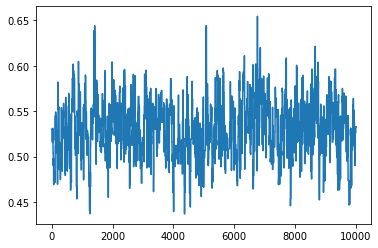

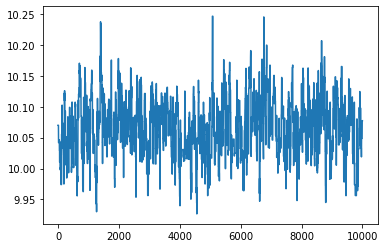

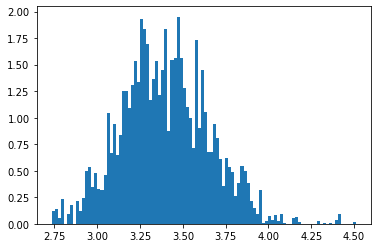

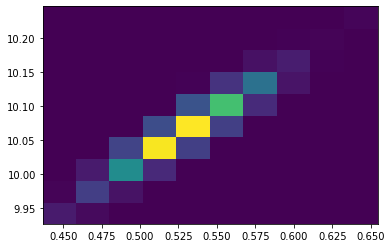

In [65]:
N = 4.302e-6
N=10**4               ################## 10**5 samples overloads output, reduced to 10**4
y0=10.07               
x0=0.53                
sigma_x=0.05
sigma_y=0.05
###### after going through part A and interpreting the figures, setting ininitla points to
###### y0=10.07 and x0=0.53 eliminates burn in period while leaving sigma_x and sigma_y
###### unchanged

def chi_sq(x,y):
    a = 10**x
    Mtot = 10**y
    M = Mtot*radius**3/(a+radius)**3
    f = np.sqrt(GN*M/radius)  
    return np.sum((f-mu)**2/sigma**2)

def P(x,y):
    return np.exp(-0.5*chi_sq(x,y))
x_samples=[x0]
y_samples=[y0]

for i in range(N-1):
  x_old=x_samples[i]
  y_old=y_samples[i]
  x_new=np.random.normal(x_old,sigma_x)
  y_new=np.random.normal(y_old,sigma_y)
  A=P(x_new,y_new)/P(x_old,y_old)
  if A>1:
    x_samples.append(x_new)
    y_samples.append(y_new)
  else:
    r=np.random.rand()
    if r< A:
      x_samples.append(x_new)
      y_samples.append(y_new)
    else:
      x_samples.append(x_old)
      y_samples.append(y_old)

plt.figure(1)
plt.plot(x_samples)
plt.figure(2)
plt.plot(y_samples)




def a(x):
  return np.power(10,x)
def Mtot(x):
  return np.power(10,x)
print('the mean of  variable a is',np.mean(a(x_samples)))
print('the uncertainty of  variable a is', np.std(a(x_samples)))
print('the mean of Mtot is',np.mean(Mtot(y_samples)))
print('the uncertainty of Mtot is',np.std(Mtot(y_samples)))
plt.figure(3)
plt.hist(a(x_samples),bins=100,density=True, Label="a(x_samples)")
plt.figure(4)
plt.hist(Mtot(y_samples),bins=100,density=True, Label="Mtot(y_samples)")
plt.hist2d(x_samples,y_samples,density=True)

## <font color=#46769B>Part (c)</font>

For situations where the variables are correlated, it can be helpful to sample from a multivariate normal distribution.
Repeat part (b) except now sample $x,y$ from a multivariate distribution with a nondiagonal covariance matrix $C$.
You may use your samples from part (b) to tune $C$, as well as your initial points $x_0,y_0$.

After you are happy with your parameters:
- Make plots of the samples in your chain.

Using only the burned-in part of your chain:
- From your samples, compute the mean $\langle M_{\rm tot} \rangle$ and uncertainty $\Delta M_{\rm tot}$.
- From your samples, compute the mean $\langle a \rangle$ and uncertainty $\Delta a$.
- Plot marginalized histograms for $M_{\rm tot}$ and $a$.
